In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
#pre define values for the nbeats (from paper Table:18)
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

N_EPOCHS = 250 # "Iterations" (5000)
N_NEURONS = 512 # "Width" 
N_LAYERS = 4 # "Block-layers"
N_STACKS = 30 #"Stacks"
BATCH_SIZE=125 #"Bath"(1024)
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback period" 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [3]:
# to get the data in form of date(as index) an values ie.(univariate)

data1=pd.read_csv('dataset50/7.csv',index_col=False )
data1=data1.drop(['Unnamed: 0'],axis=1)
# unit='s' to convert it into epoch time
data1['Modified Datetime'] = pd.to_datetime(data1['timestamp'],
                                      unit='ms')

data1['Datetime'] = data1['Modified Datetime'].dt.strftime('%d-%m-%Y %H:%M:%S')
data1=data1.drop(['timestamp','Modified Datetime'],axis=1)
datetime_series = pd.to_datetime(data1['Datetime'])

datetime_index = pd.DatetimeIndex(datetime_series.values)
data=data1.set_index(datetime_index)
data.drop('Datetime',axis=1,inplace=True)
#preparing windowed data by adding the windowed column 
data_nbeats = data.copy()
for i in range(WINDOW_SIZE):
    data_nbeats[f"value+{i+1}"] = data_nbeats["value"].shift(periods=i+1)
data_nbeats.dropna().head()
    
X = data_nbeats.dropna().drop("value", axis=1)
y = data_nbeats.dropna()["value"]
# Make train and test set split
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)
#train and test data set 
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [4]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, # the constructor takes all the hyperparameters for the layer
                   input_size: int,
                   theta_size: int,
                   horizon: int,
                   n_neurons: int,
                   n_layers: int,
                   **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        # Output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs): # the call method is what runs when the layer is called 
            x = inputs # pass inputs through each hidden layer 
            for layer in self.hidden:
                x = layer(x)
            theta = self.theta_layer(x) 
            # Output the backcast and forecast from theta
            backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
            return backcast, forecast




In [5]:

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS)

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE))

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast]) 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):# first stack is already creted in (3)
    # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
    backcast, block_forecast = NBeatsBlock(
          input_size=INPUT_SIZE,
          theta_size=THETA_SIZE,
          horizon=HORIZON,
          n_neurons=N_NEURONS,
          n_layers=N_LAYERS,
          
      )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
    residuals = layers.subtract([residuals, backcast]) 
    forecast = layers.add([forecast, block_forecast])

# 7. Put the stack model together
NBeatmodel = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="NBeatmodel")

# 8. Compile with MAE loss and Adam optimizer
NBeatmodel.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse","mape"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
NBeatmodel.fit(train_dataset,
            epochs=N_EPOCHS)

Epoch 1/250
5/5 [==============================] - 6s 205ms/step - loss: 9940.6084 - mae: 9940.6084 - mse: 323593664.0000 - mape: 679.5883
Epoch 2/250
5/5 [==============================] - 1s 207ms/step - loss: 699.7448 - mae: 699.7448 - mse: 791810.4375 - mape: 47.7056
Epoch 3/250
5/5 [==============================] - 1s 207ms/step - loss: 262.6786 - mae: 262.6786 - mse: 102335.9062 - mape: 17.9087
Epoch 4/250
5/5 [==============================] - 1s 210ms/step - loss: 179.7270 - mae: 179.7270 - mse: 52816.3125 - mape: 12.9198
Epoch 5/250
5/5 [==============================] - 1s 207ms/step - loss: 157.4102 - mae: 157.4102 - mse: 41900.5781 - mape: 11.1015
Epoch 6/250
5/5 [==============================] - 1s 206ms/step - loss: 145.5538 - mae: 145.5538 - mse: 37342.4883 - mape: 10.2905
Epoch 7/250
5/5 [==============================] - 1s 206ms/step - loss: 140.0307 - mae: 140.0307 - mse: 34874.2461 - mape: 9.8274
Epoch 8/250
5/5 [==============================] - 1s 204ms/step - l

5/5 [==============================] - 1s 217ms/step - loss: 127.4169 - mae: 127.4169 - mse: 27864.5488 - mape: 8.6768
Epoch 64/250
5/5 [==============================] - 1s 215ms/step - loss: 126.4479 - mae: 126.4479 - mse: 27124.9199 - mape: 8.7669
Epoch 65/250
5/5 [==============================] - 1s 218ms/step - loss: 119.6965 - mae: 119.6965 - mse: 25822.9609 - mape: 8.2278
Epoch 66/250
5/5 [==============================] - 1s 214ms/step - loss: 106.9876 - mae: 106.9876 - mse: 21923.7402 - mape: 7.2818
Epoch 67/250
5/5 [==============================] - 1s 214ms/step - loss: 92.1342 - mae: 92.1342 - mse: 17577.3848 - mape: 6.2935
Epoch 68/250
5/5 [==============================] - 1s 206ms/step - loss: 86.3466 - mae: 86.3466 - mse: 15556.6807 - mape: 5.9026
Epoch 69/250
5/5 [==============================] - 1s 211ms/step - loss: 80.7661 - mae: 80.7661 - mse: 13842.6924 - mape: 5.5020
Epoch 70/250
5/5 [==============================] - 1s 211ms/step - loss: 81.3512 - mae: 81.351

5/5 [==============================] - 1s 209ms/step - loss: 57.1696 - mae: 57.1696 - mse: 7085.7847 - mape: 3.9000
Epoch 126/250
5/5 [==============================] - 1s 213ms/step - loss: 69.5988 - mae: 69.5988 - mse: 8667.1152 - mape: 4.7368
Epoch 127/250
5/5 [==============================] - 1s 208ms/step - loss: 62.3676 - mae: 62.3676 - mse: 7509.5703 - mape: 4.3422
Epoch 128/250
5/5 [==============================] - 1s 214ms/step - loss: 63.4732 - mae: 63.4732 - mse: 8106.2861 - mape: 4.3740
Epoch 129/250
5/5 [==============================] - 1s 211ms/step - loss: 56.7012 - mae: 56.7012 - mse: 6821.8247 - mape: 3.8593
Epoch 130/250
5/5 [==============================] - 1s 208ms/step - loss: 63.1095 - mae: 63.1095 - mse: 8064.9175 - mape: 4.3007
Epoch 131/250
5/5 [==============================] - 1s 213ms/step - loss: 61.5114 - mae: 61.5114 - mse: 7662.1152 - mape: 4.1860
Epoch 132/250
5/5 [==============================] - 1s 213ms/step - loss: 62.9310 - mae: 62.9310 - mse:

5/5 [==============================] - 1s 208ms/step - loss: 43.6584 - mae: 43.6584 - mse: 3531.4792 - mape: 2.9467
Epoch 189/250
5/5 [==============================] - 1s 205ms/step - loss: 37.5504 - mae: 37.5504 - mse: 2713.9617 - mape: 2.5343
Epoch 190/250
5/5 [==============================] - 1s 210ms/step - loss: 37.4576 - mae: 37.4576 - mse: 2581.0129 - mape: 2.5229
Epoch 191/250
5/5 [==============================] - 1s 206ms/step - loss: 41.9282 - mae: 41.9282 - mse: 3189.3682 - mape: 2.8567
Epoch 192/250
5/5 [==============================] - 1s 207ms/step - loss: 41.0872 - mae: 41.0872 - mse: 3122.1213 - mape: 2.7672
Epoch 193/250
5/5 [==============================] - 1s 202ms/step - loss: 47.9011 - mae: 47.9011 - mse: 4524.8652 - mape: 3.1880
Epoch 194/250
5/5 [==============================] - 1s 199ms/step - loss: 45.3490 - mae: 45.3490 - mse: 4230.7227 - mape: 3.0144
Epoch 195/250
5/5 [==============================] - 1s 203ms/step - loss: 40.4588 - mae: 40.4588 - mse:

In [6]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions

In [7]:
NBeatmodel_preds = make_preds(NBeatmodel, test_dataset)
NBeatmodel_preds

2/2 [==============================] - 1s 77ms/step


<tf.Tensor: shape=(209,), dtype=float32, numpy=
array([1654.334  , 1551.2063 , 1273.3784 , 1368.8915 , 1549.3978 ,
       1239.5483 , 1335.8647 , 1111.5682 , 1213.3387 , 1584.4458 ,
       1158.9985 , 1430.273  , 1668.3937 , 1815.6482 , 1836.223  ,
       1807.5619 , 1635.1107 , 1739.3417 , 1781.1913 , 1789.7563 ,
       1789.1992 , 1720.257  , 1725.6155 , 1530.777  , 1791.3214 ,
       1466.7318 , 1756.7675 , 1563.9774 , 1306.8203 , 1363.7468 ,
       1231.8695 , 1310.9156 , 1530.5083 , 1492.4818 , 1201.0288 ,
       1529.8429 , 1739.5962 , 1605.8994 , 1671.7468 , 1813.9547 ,
       1821.7318 , 1915.7494 , 1855.2296 , 1730.7006 , 1890.4678 ,
       1741.9711 , 1670.4727 , 1716.6497 , 1560.0466 , 1806.9897 ,
       1524.2506 , 1500.9419 , 1637.729  , 1109.4037 ,  896.03674,
       1176.6855 , 1219.3314 , 1109.1139 , 1121.8004 , 1611.0568 ,
       1626.6808 , 1638.312  , 1641.2864 , 1734.1969 , 1868.5669 ,
       1898.7498 , 1934.7338 , 1789.3927 , 1941.9673 , 1692.1052 ,
       1806.61

In [8]:
#to get all the scores
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

   # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [9]:
# Evaluate N-BEATS model predictions
NBeatmodel_results = evaluate_preds(y_true=y_test,
                                 y_pred=NBeatmodel_preds)
NBeatmodel_results

{'mae': 173.88731, 'mse': 55525.504, 'rmse': 235.6385, 'mape': 12.27118}

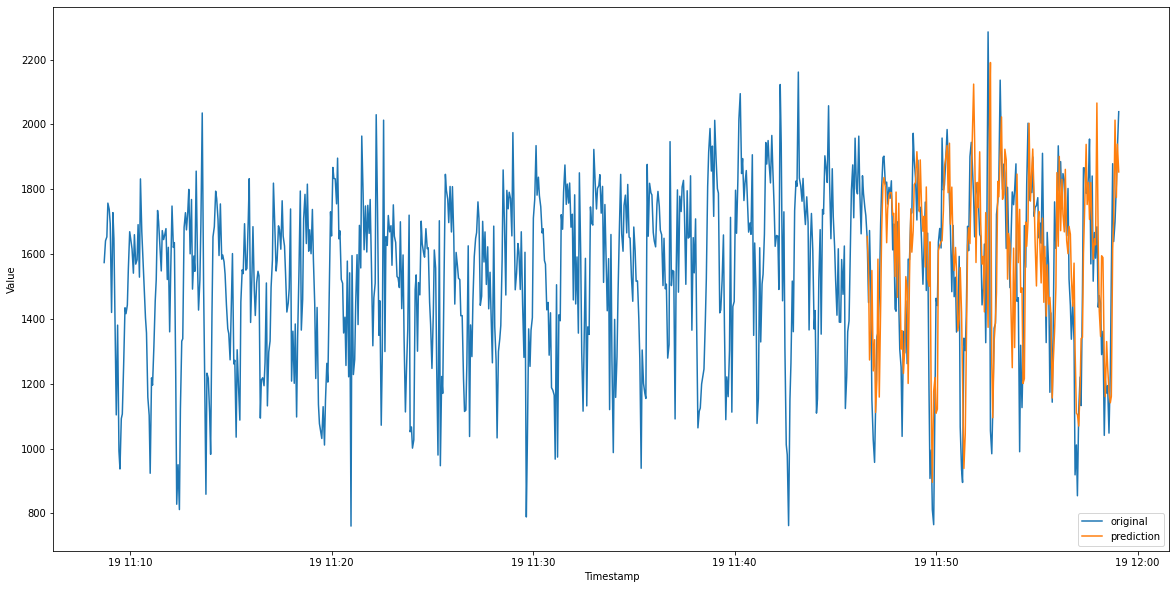

In [10]:
# Forecast Plot
x = data.index.values
y = data.value.values

plt.figure(figsize=(20, 10))
plt.plot(x,y,label="original")
plt.plot(x[(len(X_train)+7):],NBeatmodel_preds,label="prediction")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(["original", "prediction"], loc ="lower right")